# Tutorial 3: Application of AlignDG on 3D reconstruction (DLPFC, pairwise mode)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import anndata as ad
import scanpy as sc
import pandas as pd
import os
import numpy as np
from scipy import sparse
import torch
import aligndg

# set seed as 42
aligndg.set_global_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [3]:
import numpy as np
from scipy import spatial

def mapping_accuracy_ot(labels1, labels2, pi):
    mapping_dict = {'Layer_1': 1, 'Layer_2': 2, 'Layer_3': 3, 'Layer_4': 4, 'Layer_5': 5, 'Layer_6': 6, 'WM': 7}
    #mapping_dict = {'Layer_3':1, 'Layer_4':2, 'Layer_5':3, 'Layer_6':4, 'WM':5}
    return np.sum(pi * (spatial.distance_matrix(np.matrix(labels1.map(mapping_dict)).T, np.matrix(labels2.map(mapping_dict)).T) == 0))

def mapping_accuracy_in(labels1, labels2, pi):
    mapping_dict = {'Layer_1': 1, 'Layer_2': 2, 'Layer_3': 3, 'Layer_4': 4, 'Layer_5': 5, 'Layer_6': 6, 'WM': 7}
    #mapping_dict = {'Layer_3':1, 'Layer_4':2, 'Layer_5':3, 'Layer_6':4, 'WM':5}
    list_1 = np.nonzero(pi)
    return np.sum(pi * (spatial.distance_matrix(np.matrix(labels1.map(mapping_dict)).T, np.matrix(labels2.map(mapping_dict)).T) == 0)) / np.shape(list_1)[1]

### Load data and random rotate spatial information

In [4]:
def per_location(input_adata):
    rotate_key = 'spatial'
    theta = np.random.rand() * 2 * np.pi
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    input_adata.obsm['spatial_raw'] = input_adata.obsm['spatial'][:,: 2].copy()
    input_adata.obsm[rotate_key] = input_adata.obsm['spatial'][:,: 2].copy()
    mean = np.mean(input_adata.obsm[rotate_key], axis=0)
    input_adata.obsm[rotate_key] = input_adata.obsm[rotate_key] - mean
    input_adata.obsm[rotate_key] = input_adata.obsm[rotate_key] @ rotation_matrix.T + mean

In [5]:
paste_adata = sc.read_h5ad('/home/featurize/work/moscot/data/DLPFC/DLPFC_PASTE_processed.h5ad')
paste_adata

AnnData object with n_obs × n_vars = 14243 × 7449
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'slice_name'
    uns: 'layer_guess_colors', 'slice_name_colors'
    obsm: 'spatial'

In [6]:
from aligndg.utils.graph_construction import cal_spatial_network

section_ids = ['151673', '151674', '151675', '151676']
adata_list = []
adj_list = []

for section_id in section_ids:
    input_dir ='/home/featurize/work/moscot/data/DLPFC'
    adata = sc.read_h5ad(os.path.join(input_dir, section_id + '_preprocessed.h5'))
    adata.var_names_make_unique()
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]
    
    # convert spatial information from PASTE
    adata.obsm['spatial'] = paste_adata[paste_adata.obs['slice_name'] == section_id].obsm['spatial']

    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    adata = adata[:, adata.var['highly_variable']]
    
    cal_spatial_network(adata, model='KNN', k_cutoff=6)

    if section_id != '151673':
        per_location(adata)
    
    adj_list.append(adata.uns['adj'])
    adata_list.append(adata)

Calculating spatial neighbor graph ...
The graph contains 23691 edges, 3611 cells
6.5607864857380225 neighbors per cell on average
Calculating spatial neighbor graph ...
The graph contains 23727 edges, 3635 cells
6.527372764786795 neighbors per cell on average
Calculating spatial neighbor graph ...
The graph contains 23312 edges, 3566 cells
6.537296690970275 neighbors per cell on average
Calculating spatial neighbor graph ...
The graph contains 22401 edges, 3431 cells
6.529000291460216 neighbors per cell on average


In [7]:
adata_list[0].obsm['spatial_raw'] = adata_list[0].obsm['spatial'].copy()

### Visualize the raw (rotate) slices and corrected coordinates provided by PASTE

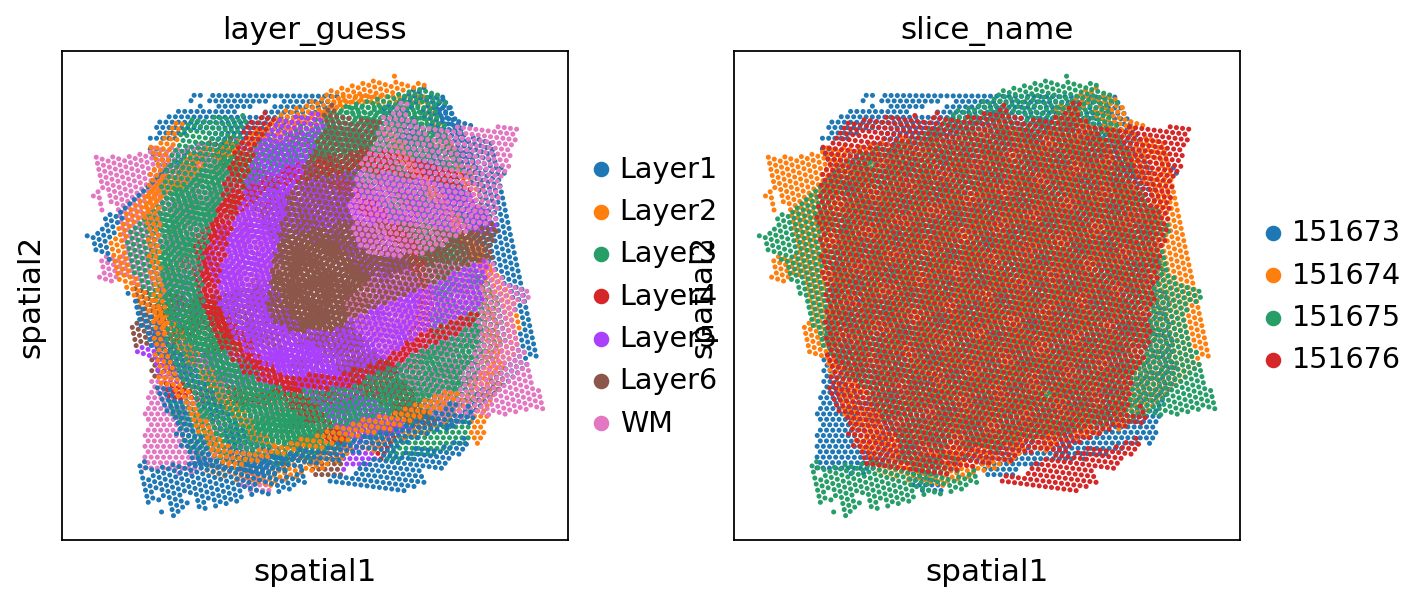

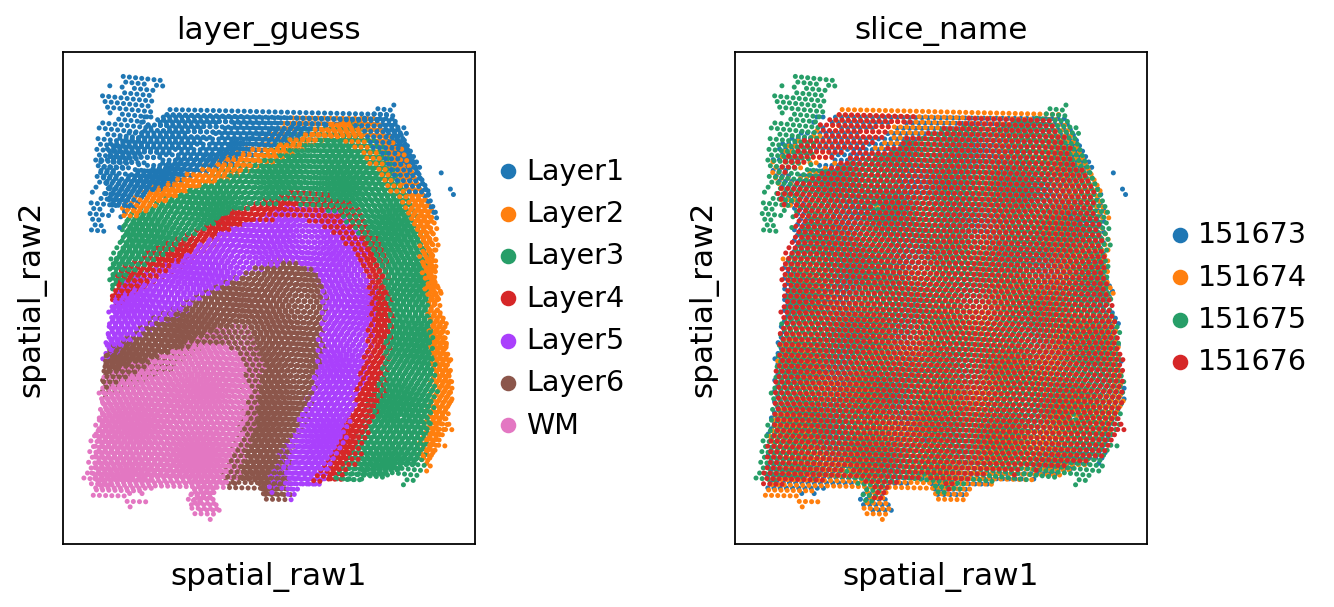

In [8]:
adata_concat = ad.concat(adata_list, label='slice_name', keys=section_ids)
sc.pl.spatial(adata_concat, basis='spatial', color=['layer_guess', 'slice_name'], spot_size=5)
sc.pl.spatial(adata_concat, basis='spatial_raw', color=['layer_guess', 'slice_name'], spot_size=5)

In [9]:
def mapping_accuracy(adatas, key_obs, pi):
    count = 0
    for i in range(pi.shape[0]):
        source_domain = adatas[0].obs[key_obs][i]
        max_align = pi[i].argsort()[-1]
        target_domain = adatas[1].obs[key_obs].values[max_align]
        if source_domain == target_domain:
            count = count + 1
    
    print(count / pi.shape[0], count, pi.shape[0])

In [10]:
from scipy.sparse import block_diag

adata_concat = ad.concat(adata_list, label='slice_name', keys=section_ids)
adj_concat = block_diag(adj_list)
adata_concat.uns['edge_list'] = np.nonzero(adj_concat)

In [11]:
adata_concat

AnnData object with n_obs × n_vars = 14243 × 7449
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'slice_name'
    uns: 'edge_list'
    obsm: 'spatial', 'X_pca', 'spatial_raw'

### Perform AlignDG with pairwise mode

In [12]:
from aligndg.graph import AlignDG
iter_comb = [(0, 1), (1, 2), (2, 3)]
adata_concat, pis = AlignDG.train_AlignDG(adata=adata_concat, beta=0.5, alpha1=1, alpha2=1, lamb=10, iter_comb=iter_comb)

  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplet at epoch 500
Processing datasets ('151673', '151674')
Solver may not converge.
Processing datasets ('151674', '151675')
Solver may not converge.
Processing datasets ('151675', '151676')
Solver may not converge.


# Epoch 599, loss: 0.208, gene_recon: 0.204, triplet loss: 0.0003602350188884884:  20%|██        | 100/500 [00:48<01:11,  5.63it/s]

Update spot triplet at epoch 600
Processing datasets ('151673', '151674')
Solver may not converge.
Processing datasets ('151674', '151675')
Solver may not converge.
Processing datasets ('151675', '151676')
Solver may not converge.


# Epoch 699, loss: 0.206, gene_recon: 0.204, triplet loss: 0.00025614883634261787:  40%|████      | 200/500 [01:33<00:53,  5.60it/s]

Update spot triplet at epoch 700
Processing datasets ('151673', '151674')
Solver may not converge.
Processing datasets ('151674', '151675')
Solver may not converge.
Processing datasets ('151675', '151676')
Solver may not converge.


# Epoch 799, loss: 0.207, gene_recon: 0.204, triplet loss: 0.00036025323788635433:  60%|██████    | 300/500 [02:19<00:35,  5.60it/s]

Update spot triplet at epoch 800
Processing datasets ('151673', '151674')
Solver may not converge.
Processing datasets ('151674', '151675')
Solver may not converge.
Processing datasets ('151675', '151676')
Solver may not converge.


# Epoch 899, loss: 0.207, gene_recon: 0.204, triplet loss: 0.00031046869116835296:  80%|████████  | 400/500 [03:04<00:17,  5.62it/s]

Update spot triplet at epoch 900
Processing datasets ('151673', '151674')
Solver may not converge.
Processing datasets ('151674', '151675')
Solver may not converge.
Processing datasets ('151675', '151676')
Solver may not converge.


# Epoch 999, loss: 0.207, gene_recon: 0.204, triplet loss: 0.000306187808746472: 100%|██████████| 500/500 [03:50<00:00,  2.17it/s]  


### Visualize the learned cell/spot embeddings

2025-10-24 09:24:05.819237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


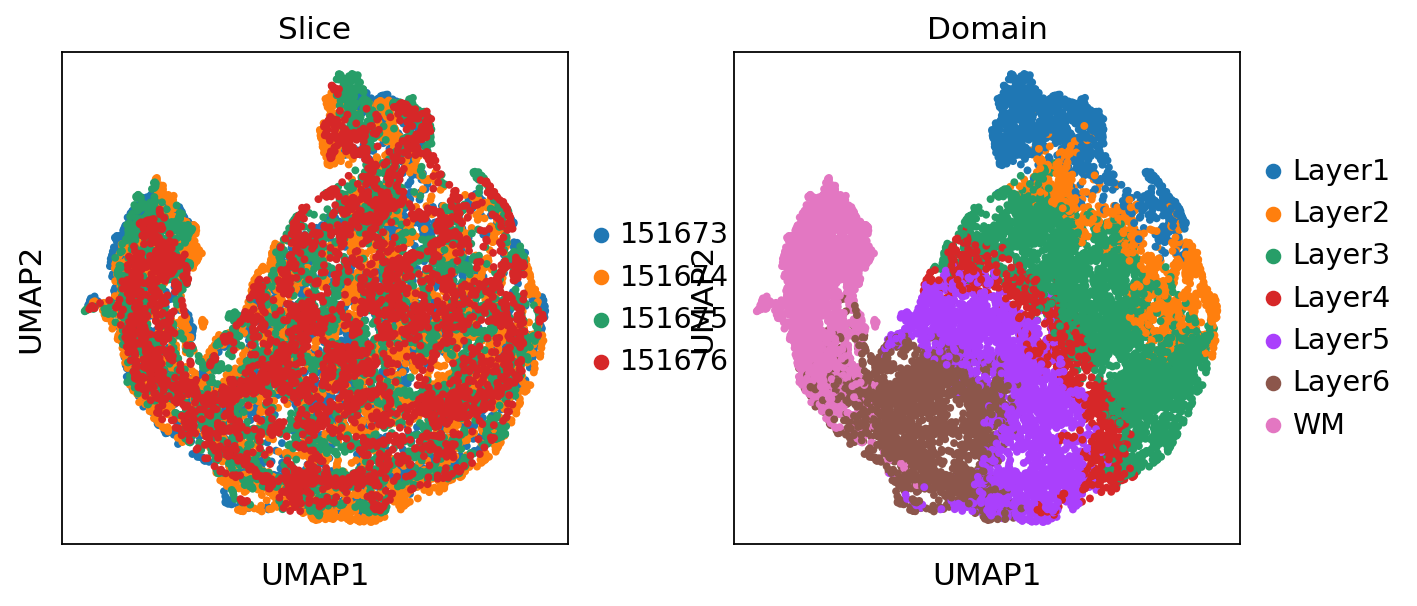

In [13]:
sc.pp.neighbors(adata_concat, use_rep='latent')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['slice_name', 'layer_guess_reordered'], title=['Slice', 'Domain'], size=50)

### Correct coordinates of slices with weighted procrustes analysis implemented by PASTE

In [14]:
import paste as pst

new_adata_list = pst.stack_slices_pairwise(adata_list, pis)

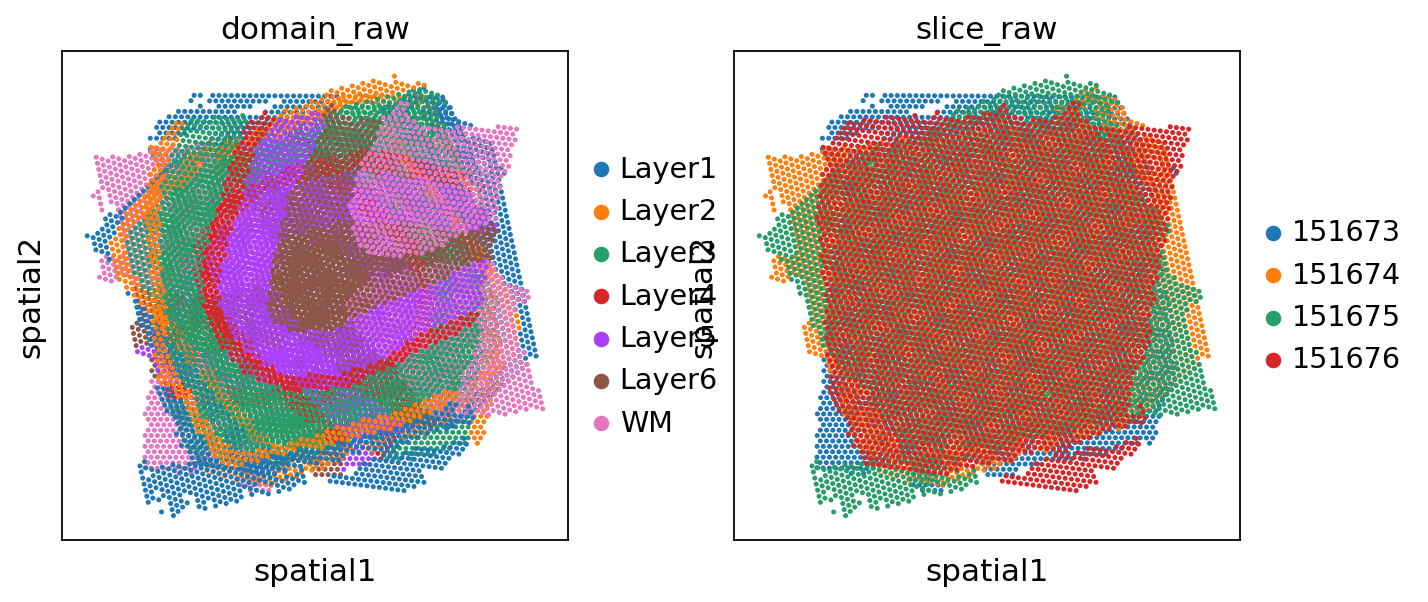

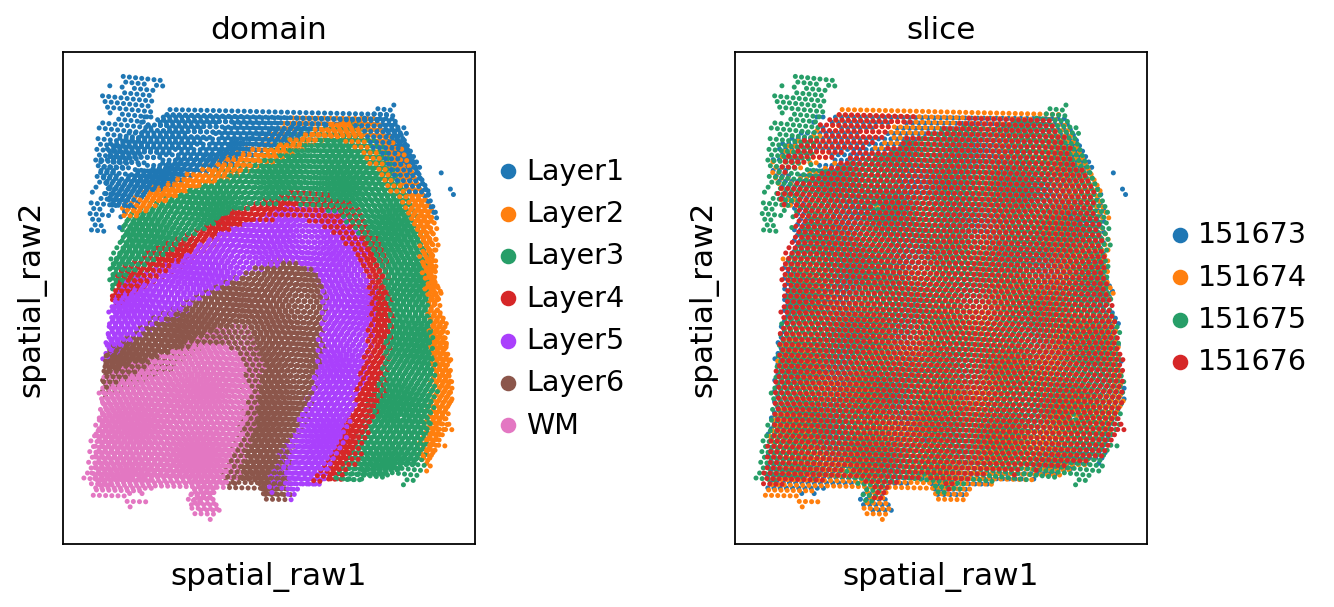

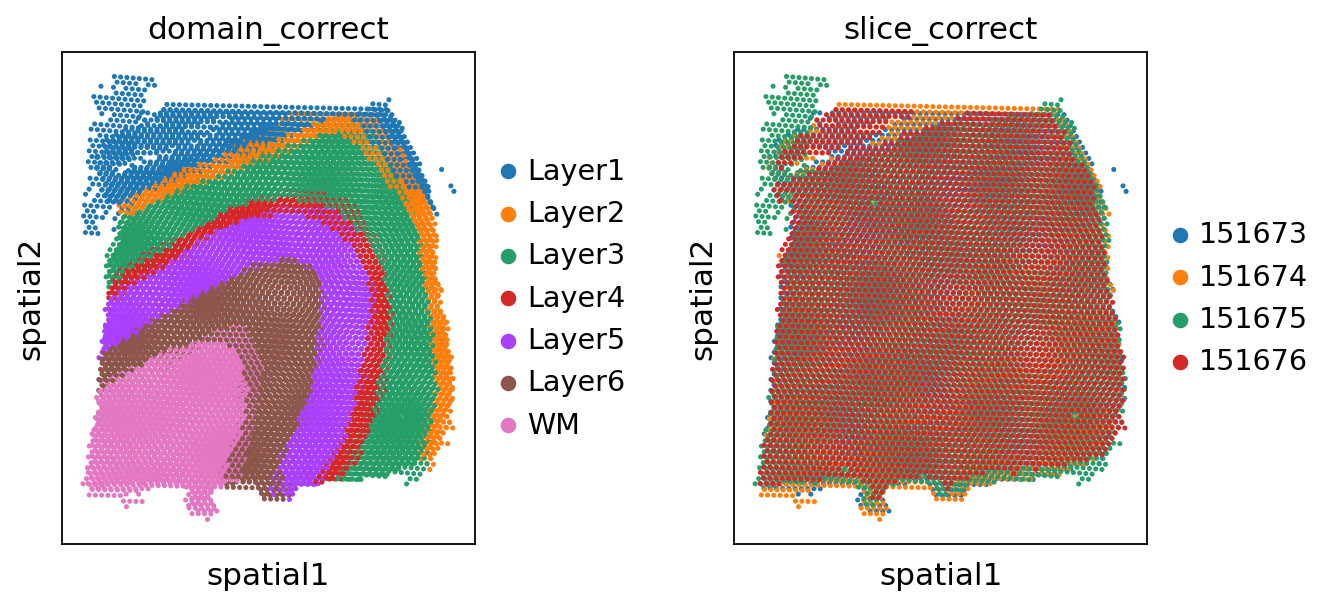

In [15]:
new_adata_concat = ad.concat(new_adata_list, label='slice_name', keys=section_ids)
sc.pl.spatial(adata_concat, color=['layer_guess', 'slice_name'], title=['domain_raw', 'slice_raw'], spot_size=5)
sc.pl.spatial(adata_concat, basis='spatial_raw', color=['layer_guess', 'slice_name'], title=['domain', 'slice'], spot_size=5)
sc.pl.spatial(new_adata_concat, color=['layer_guess', 'slice_name'], title=['domain_correct', 'slice_correct'], spot_size=5)

### Calculate different metrics

In [17]:
def mae_coords(coordsA, coordsB):
    assert coordsA.shape == coordsB.shape, "The spatial coordinates must in the same shape!"
    return np.mean(np.abs(coordsA - coordsB))

def row_wise_euclidean_dist(coordsA, coordsB):
    diff = coordsA - coordsB
    dist = np.sqrt(np.sum(diff ** 2, axis=1))
    return dist

def compute_mse_mae(coordsA, coordsB):
    diffs = coordsA - coordsB
    dist_sq = np.sum(diffs**2, axis=1)
    mse = np.mean(dist_sq)
    
    dist = np.sqrt(dist_sq)
    mae = np.mean(dist)
    
    return mse, mae

In [18]:
mae_list = []
sq_error_list = []
mae_list1 = []
sq_error_list1 = []

for i in range(len(adata_list)):
    error = mae_coords(new_adata_list[i].obsm['spatial'], adata_list[i].obsm['spatial_raw'])
    sq_error = np.linalg.norm(new_adata_list[i].obsm['spatial'] - adata_list[i].obsm['spatial_raw'], ord='fro')
    mae_list.append(error)
    sq_error_list.append(sq_error)

    mse_loss, mae_loss = compute_mse_mae(new_adata_list[i].obsm['spatial'], adata_list[i].obsm['spatial_raw'])
    sq_error_list1.append(mse_loss)
    mae_list1.append(mae_loss)
    
mae_list, sq_error_list, mae_list1, sq_error_list1

([1.66112e-05, 0.5225939003427256, 1.9747641571361045, 0.6794285194766391],
 [0.0019273096, 56.05639572348823, 200.25382529166484, 69.69515939898909],
 [3.202342e-05, 0.9296507613167181, 3.0558472873328983, 1.1783699045967524],
 [Array(1.0286686e-09, dtype=float32),
  0.864462036178352,
  11.2455396926373,
  1.4157432945644117])

In [19]:
def estimate_rotation_angle(A, B):
    A_c = A - A.mean(axis=0)
    B_c = B - B.mean(axis=0)
    
    H = A_c.T @ B_c  # shape: (2, 2)
    
    U, S, Vt = np.linalg.svd(H)
    
    d = np.linalg.det(Vt.T @ U.T)
    if d < 0:
        Vt[-1, :] *= -1
        
    R = Vt.T @ U.T  # 旋转矩阵
    angle_rad = np.arctan2(R[1, 0], R[0, 0])
    if angle_rad < 0:
        angle_rad += 2 * np.pi
        
    angle_degree = np.degrees(angle_rad)
    return angle_rad, R, angle_degree

In [20]:
angle_list = []
degree_list = []
for i in range(len(adata_list)):
    est_angle, _, est_degree = estimate_rotation_angle(new_adata_list[i].obsm['spatial'], adata_list[i].obsm['spatial_raw'])
    angle_list.append(est_angle)
    degree_list.append(est_degree)

angle_list, degree_list

([6.2831853044503,
  6.28303126486966,
  0.020748229380979144,
  0.0017884283641430483],
 [359.9999998436234,
  359.99117402577474,
  1.1887859758994375,
  0.1024693972268826])

### 3D Visualization

In [21]:
for i in range(len(section_ids)):
    coords3D = np.insert(new_adata_list[i].obsm['spatial'], 2, i, axis=1)  
    new_adata_list[i].obsm['spatial_rec3d'] = coords3D

new_adata_concat = ad.concat(new_adata_list, label='slice_name', keys=section_ids)
new_adata_concat

AnnData object with n_obs × n_vars = 14243 × 7449
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'slice_name'
    obsm: 'spatial', 'X_pca', 'spatial_raw', 'spatial_rec3d'

In [22]:
coords3d_adata_concat = ad.concat(new_adata_list, label='slice_name', keys=section_ids)
coords3d_adata_concat

AnnData object with n_obs × n_vars = 14243 × 7449
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'slice_name'
    obsm: 'spatial', 'X_pca', 'spatial_raw', 'spatial_rec3d'

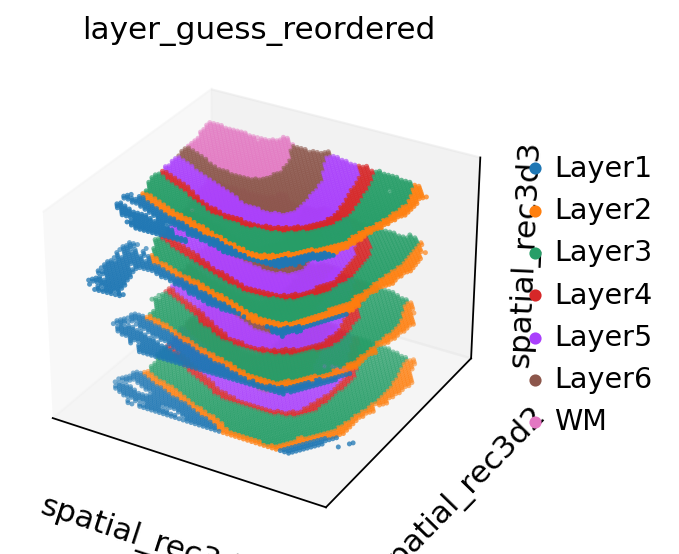

In [23]:
sc.pl.embedding(coords3d_adata_concat, basis="spatial_rec3d", projection="3d", color="layer_guess_reordered")

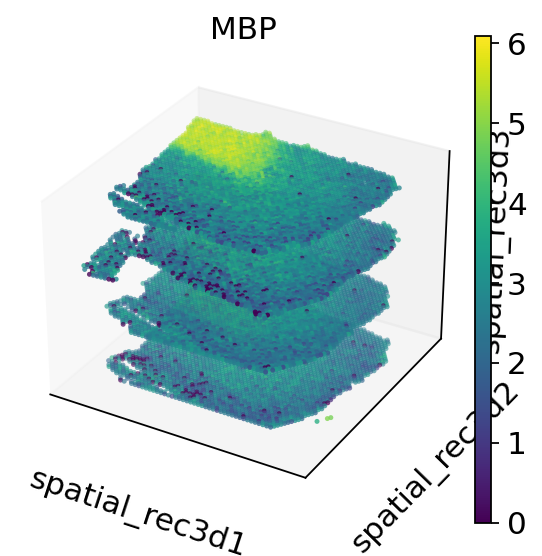

In [24]:
sc.pl.embedding(coords3d_adata_concat, basis="spatial_rec3d", projection="3d", color=['MBP'], cmap="viridis")